# Pietų Korėjos asmeninių pajamų analizė
- Pajamų skirtumai tarp lyčių
- Pajamų priklausomybė nuo amžiaus, išsilavinimo, regiono
- Pokyčiai per 14 metų

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf

#year : study conducted
#wave : from wave 1st in 2005 to wave 14th in 2018
#region: 1) Seoul 2) Kyeong-gi 3) Kyoung-nam 4) Kyoung-buk 
#5) Chung-nam 6) Gang-won &. Chung-buk 7) Jeolla & Jeju
#income: yearly income in M KRW(Million Korean Won. 1100 KRW = 1 USD)
#family_member: no. of family members
#gender(1 = male, 0 = female)
#year_born
#education_level: 1) no education(under 7 yrs-old) 2) no education(7 & over 7 yrs-old) 3) elementary 4) middle school 
#5) high school 6) college 7) university degree 8) MA 9) doctoral degree
#marriage: marital status. 1) not applicable (under 18) 2) married 3) separated by death 4) separated 5) not married yet 6) others
#religion: (1 = have religion, 0 = do not have)
#occupation: this will be provided in separated code book
#company_size
#reason_none_worker: 0) no data 1) no capable 2) in military service 3) studying in school 4) prepare for school 5) preprare to apply job 
#6) house worker 7) caring kids at home 8) nursing 9) giving-up economic activities 10) no intention to work 11) others

In [45]:
df = pd.read_csv('Korea Income and Welfare.csv')

In [46]:
df['income'] =((df['income'] * 1000_000) / 16080 / 12).round(2)

In [47]:
df.loc[ df['gender'] == 2, 'gender'] = 0
df.loc[df['religion'] == 2, 'religion'] = 0
df.loc[df['reason_none_worker'] == ' ', 'reason_none_worker'] = 0
df['reason_none_worker'] = df['reason_none_worker'].astype(int)
df.loc[df['reason_none_worker'] == 99, 'reason_none_worker'] = 0
df.loc[df['occupation'] == ' ', 'occupation'] = 0
df['occupation'] = df['occupation'].astype(int)
df.loc[df['company_size'] == ' ', 'company_size'] = 0
df['company_size'] = df['company_size'].astype('int');

df['age'] = df['year'] - df['year_born']
df = df.drop(['year', 'year_born'], axis=1)

df['been_married'] = (df['marriage'] == 2) | (df['marriage'] == 3) | (df['marriage'] == 4)
df['employed'] = df['occupation'] != 0

In [48]:
df.head()

,id,wave,region,income,family_member,gender,education_level,marriage,religion,occupation,company_size,reason_none_worker,age,been_married,employed
0,10101,1,1,3182.01,1,0,2,2,0,0,0,8,69,True,False
1,10101,7,1,4643.45,1,0,2,2,0,0,0,10,75,True,False
2,10101,8,1,6788.97,1,0,2,2,0,0,0,10,76,True,False
3,10101,9,1,11442.79,1,0,2,2,0,0,0,1,77,True,False
4,10101,10,1,4477.61,1,0,2,2,0,0,0,10,78,True,False


In [49]:
df.isnull().sum()

id                    0
wave                  0
region                0
income                0
family_member         0
gender                0
education_level       0
marriage              0
religion              0
occupation            0
company_size          0
reason_none_worker    0
age                   0
been_married          0
employed              0
dtype: int64

In [50]:
df.columns

Index(['id', 'wave', 'region', 'income', 'family_member', 'gender',
       'education_level', 'marriage', 'religion', 'occupation', 'company_size',
       'reason_none_worker', 'age', 'been_married', 'employed'],
      dtype='object')

In [51]:
len(df)

92857

In [52]:
df.describe().round(2)

,id,wave,region,income,family_member,gender,education_level,marriage,religion,occupation,company_size,reason_none_worker,age
count,92857.00,92857.00,92857.00,92857.00,92857.00,92857.00,92857.00,92857.00,92857.00,92857.00,92857.00,92857.00,92857.00
mean,43651814.13,7.52,3.69,17833.35,2.48,0.70,4.51,1.68,0.51,393.19,2.19,2.94,58.56
std,26190073.03,4.01,2.06,21643.47,1.29,0.46,1.67,1.10,0.54,379.94,3.18,4.33,16.20
min,10101.00,1.00,1.00,-1203223.47,1.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,11.00
25%,21771201.00,4.00,2.00,5907.96,1.00,0.00,3.00,1.00,0.00,0.00,0.00,0.00,45.00
50%,43220101.00,8.00,3.00,12582.92,2.00,1.00,5.00,1.00,1.00,314.00,1.00,0.00,60.00
75%,61900301.00,11.00,5.00,24331.47,3.00,1.00,5.00,2.00,1.00,741.00,3.00,8.00,72.00
max,98000701.00,14.00,7.00,2426456.26,9.00,1.00,9.00,9.00,9.00,9999.00,99.00,11.00,99.00


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92857 entries, 0 to 92856
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  92857 non-null  int64  
 1   wave                92857 non-null  int64  
 2   region              92857 non-null  int64  
 3   income              92857 non-null  float64
 4   family_member       92857 non-null  int64  
 5   gender              92857 non-null  int64  
 6   education_level     92857 non-null  int64  
 7   marriage            92857 non-null  int64  
 8   religion            92857 non-null  int64  
 9   occupation          92857 non-null  int32  
 10  company_size        92857 non-null  int32  
 11  reason_none_worker  92857 non-null  int32  
 12  age                 92857 non-null  int64  
 13  been_married        92857 non-null  bool   
 14  employed            92857 non-null  bool   
dtypes: bool(2), float64(1), int32(3), int64(9)
memory usa

In [54]:
df.groupby('gender')['income'].mean() / 1000

gender
0     8.536680
1    21.748098
Name: income, dtype: float64

In [55]:
pd.pivot_table(data=df, 
            index='company_size',
            columns = 'gender',
            values='income',
            aggfunc='mean').fillna(0) / 1000

gender,0,1
company_size,,
0,6.191854,11.414734
1,10.315274,19.879345
2,13.344521,25.728716
3,12.416181,26.149946
4,14.223050,25.778288
5,14.836183,27.591148
6,16.641675,28.274388
7,14.697545,28.400014
8,16.407339,30.313060


In [56]:
df.groupby('gender')['education_level'].mean()

gender
0    3.430311
1    4.967341
Name: education_level, dtype: float64

<AxesSubplot:xlabel='age', ylabel='Count'>

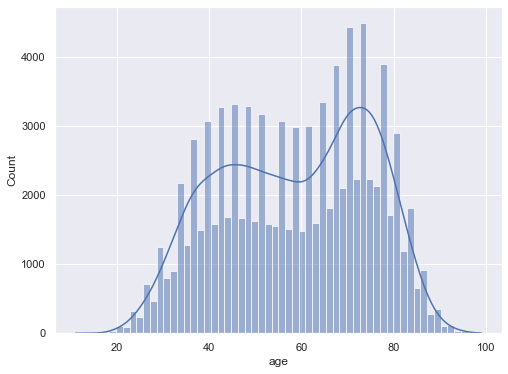

In [57]:
sns.set(rc={'figure.figsize':(8,6)})
sns.histplot(df['age'], bins=60, kde=True)

<AxesSubplot:xlabel='company_size', ylabel='count'>

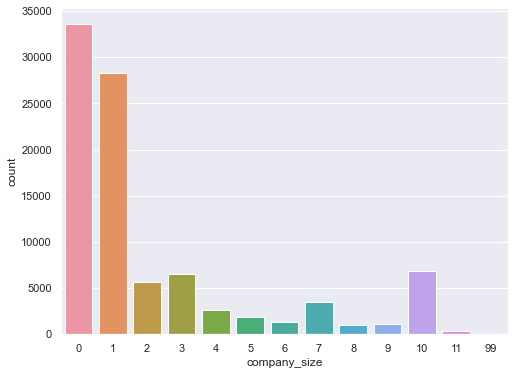

In [58]:
sns.countplot(data=df, x='company_size')

<AxesSubplot:xlabel='age', ylabel='income_log'>

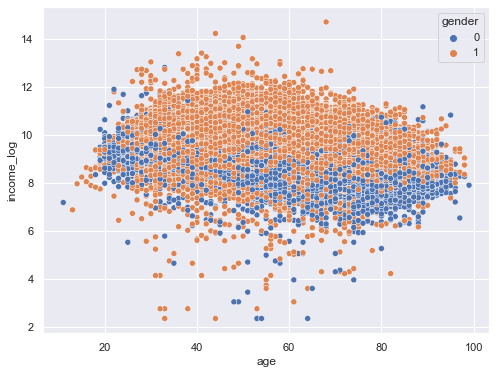

In [59]:
df = df.loc[df['income'] > 0]
df['income_log'] = np.log(df['income'])
sns.scatterplot(x="age", y="income_log", hue="gender", data=df)

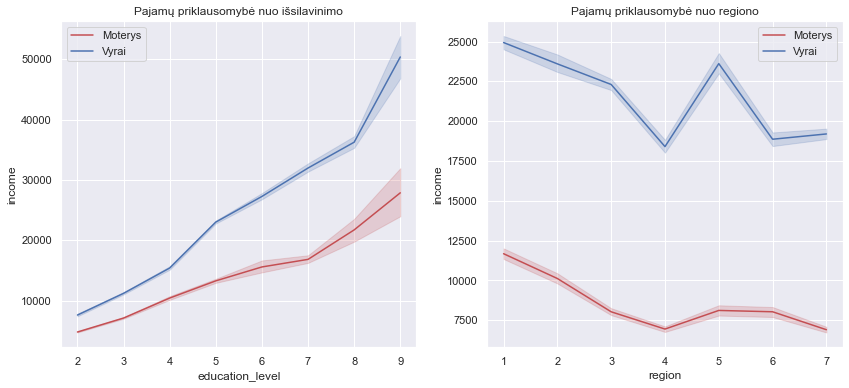

In [60]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.lineplot(x="education_level", y="income", hue="gender", ax = axs[0], palette=["r", "b"], data=df)
sns.lineplot(x="region", y="income", hue="gender", ax = axs[1], palette=["r", "b"], data=df)


axs[0].set_title("Pajamų priklausomybė nuo išsilavinimo")
axs[0].legend(labels=["Moterys","Vyrai"])
axs[1].set_title("Pajamų priklausomybė nuo regiono")
axs[1].legend(labels=["Moterys","Vyrai"])

<AxesSubplot:xlabel='company_size', ylabel='income_log'>

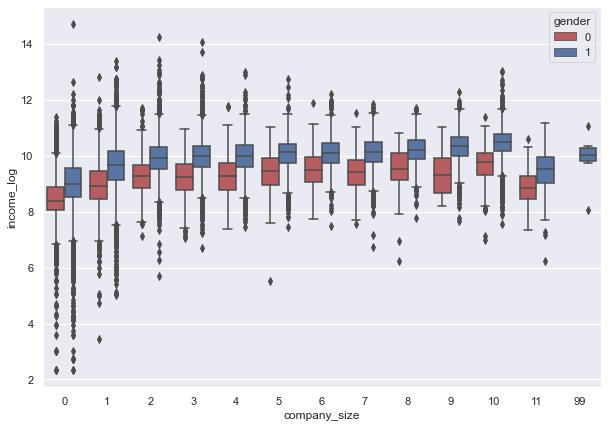

In [61]:
sns.set(rc={'figure.figsize':(10,7)})
sns.boxplot(x="company_size", y="income_log", hue="gender", palette=["r", "b"], data=df)

<AxesSubplot:xlabel='age', ylabel='income'>

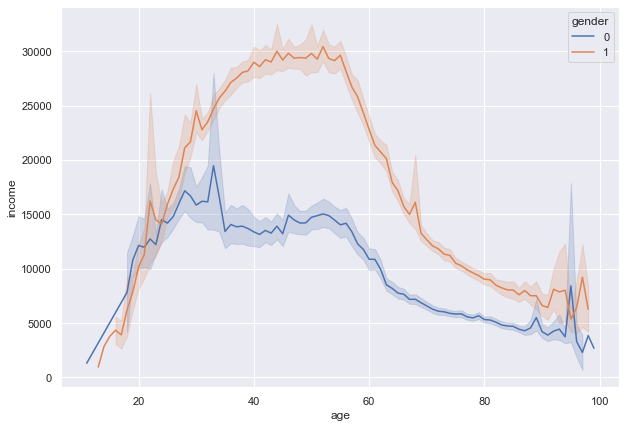

In [62]:
sns.lineplot( data=df, x='age',y='income', hue='gender' )

<AxesSubplot:xlabel='gender', ylabel='company_size'>

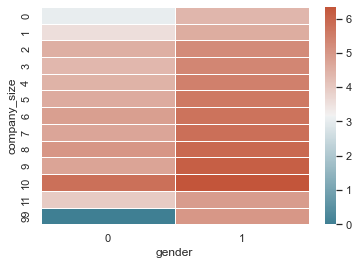

In [63]:

table_education = pd.pivot_table(data=df, 
               index='company_size',
               columns = 'gender',
               values='education_level',
               aggfunc='mean').fillna(0)

cmap = sns.diverging_palette(220, 20, as_cmap=True)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

sns.heatmap(table_education, cmap=cmap, linewidth=1, ax=ax)

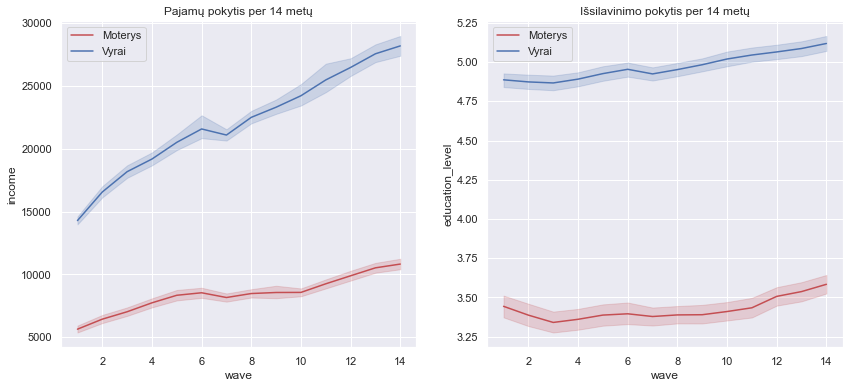

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.lineplot(x="wave", y="income", hue="gender", ax = axs[0], palette=["r", "b"], data=df)
sns.lineplot(x="wave", y="education_level", hue="gender", ax = axs[1], palette=["r", "b"], data=df)

axs[0].set_title("Pajamų pokytis per 14 metų")
axs[0].legend(labels=["Moterys","Vyrai"])
axs[1].set_title("Išsilavinimo pokytis per 14 metų")
axs[1].legend(labels=["Moterys","Vyrai"])

In [65]:
df['Seoul'] = (df['region'] == 1).astype(int)
df['Kyeong_gi'] = (df['region'] == 2).astype(int)
df['Kyoung_nam'] = (df['region'] == 3).astype(int)
df['Kyoung_buk'] = (df['region'] == 4).astype(int)
df['Chung_nam'] = (df['region'] == 5).astype(int)
df['Gang_won_Chung_buk'] = (df['region'] == 6).astype(int)
df['Jeolla_Jeju'] = (df['region'] == 7).astype(int)

In [66]:
df_reg = df[['family_member', 'gender', 'education_level', 'been_married', 'religion', 'company_size', 'age']]
df_reg.corr()

,family_member,gender,education_level,been_married,religion,company_size,age
family_member,1.000000,0.493524,0.418342,-0.521057,-0.049418,0.310245,-0.471143
gender,0.493524,1.000000,0.420688,-0.749133,-0.129101,0.231244,-0.290555
education_level,0.418342,0.420688,1.000000,-0.454115,-0.043131,0.438684,-0.628524
been_married,-0.521057,-0.749133,-0.454115,1.000000,0.090475,-0.270270,0.380557
religion,-0.049418,-0.129101,-0.043131,0.090475,1.000000,-0.058295,0.131751
company_size,0.310245,0.231244,0.438684,-0.270270,-0.058295,1.000000,-0.487856
age,-0.471143,-0.290555,-0.628524,0.380557,0.131751,-0.487856,1.000000


In [67]:
columns = ['family_member', 'gender', 'education_level', 'been_married', 'religion', 'company_size', 'age', 'Seoul', 'Kyeong_gi', 'Kyoung_nam', 'Kyoung_buk', 'Chung_nam', 'Gang_won_Chung_buk', 'Jeolla_Jeju']

y = df['income']
X = df[columns]

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,)

In [69]:
model = LinearRegression()

In [70]:
model.fit(X_train, y_train)

LinearRegression()

In [71]:
coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficients'])
coeff_df

,Coefficients
family_member,4780.553973
gender,103.552606
education_level,3022.162828
been_married,-908.829913
religion,-154.381072
company_size,1111.655727
age,69.185451
Seoul,840.431161
Kyeong_gi,548.031215
Kyoung_nam,757.515528


In [72]:
predictions = model.predict(X_test)

In [73]:
print("Pirmasis atlyginimas yra", y_test.iloc[0])
print("Pirmasis spejamas atlyginimas yra", predictions[0])

Pirmasis atlyginimas yra 4208.13
Pirmasis spejamas atlyginimas yra 2331.632269608679


Text(0, 0.5, 'Spėjamas atlyginimas')

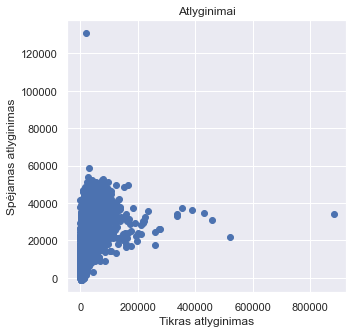

In [74]:
fig, ax = plt.subplots(1,1, figsize=(5,5))


ax.scatter(x=y_test, y=predictions)


ax.set_title("Atlyginimai")
ax.set_xlabel("Tikras atlyginimas")
ax.set_ylabel("Spėjamas atlyginimas")

In [75]:
from sklearn.metrics import r2_score
r2_score(y_test, predictions)

0.35470607477348304

In [76]:
model = smf.ols(formula='income ~ family_member + gender + education_level + been_married + religion + company_size + age + Seoul + Kyeong_gi + Kyoung_nam + Kyoung_buk + Chung_nam + Gang_won_Chung_buk + Jeolla_Jeju', data=df).fit()

In [77]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 income   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     2766.
Date:                Mon, 23 May 2022   Prob (F-statistic):               0.00
Time:                        07:41:41   Log-Likelihood:            -1.0387e+06
No. Observations:               92625   AIC:                         2.077e+06
Df Residuals:                   92611   BIC:                         2.078e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -1.195e+04    447.648    -26.705      0.000   -1.28e+04   -1.11e+04
been_married[T.True]  -892.8561    201.667     -4.427      0.000   -1288.120    -497.592
family_member         4779.6838     58.301     81.982      0.000    4665.414    4893.954
gender                 130.7378    202.488      0.646      0.519    -266.137     527.612
education_level       2963.5209     49.541     59.820      0.000    2866.422    3060.620
religion              -143.5732    111.804     -1.284      0.199    -362.708      75.561
company_size          1154.5565     21.692     53.225      0.000    1112.041    1197.072
age                     68.8436      5.188     13.270      0.000      58.675      79.012
Seoul                 -738.1031    158.472     -4.658      0.000   -1048.706    -427.500
Kyeong_gi            -1222.1254    140.458     -8.701      0.000   -1497.421    -946.830
Kyoung_nam            -922.6857    148.748     -6.203      0.000   -1214.230    -631.141
Kyoung_buk           -2864.5156    164.224    -17.443      0.000   -3186.393   -2542.638
Chung_nam             -536.8302    194.545     -2.759      0.006    -918.136    -155.524
Gang_won_Chung_buk   -2806.0127    204.789    -13.702      0.000   -3207.398   -2404.628
Jeolla_Jeju          -2864.1928    149.516    -19.156      0.000   -3157.242   -2571.144
==============================================================================
Omnibus:                   273133.595   Durbin-Watson:                   1.217
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      71050819905.998
Skew:                          41.288   Prob(JB):                         0.00
Kurtosis:                    4292.885   Cond. No.                     1.25e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.2e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Labai didelė atskirtis tarp vyrų ir moterų pajamų. Vidutiniškai vyrų pajamos daugiau negu dvigubai didesnės už moterų, viena iš priežasčių - išsilavinimo lygio skirtumas, bet net su tuo pačiu išsilavinimu moterys uždirba kone perpus mažiau. 

Didžiausia atsikrtis Chung-nam regione, mažiausia Kyoung-buk. Pajamos apskrtitai per visus analizės metus didėjo abiems lytims, per keturiolika metų padvigubėjo. 